
# Laboratorio 6: **Temporal-Difference Learning** en *Blackjack-v1*

**Curso:** Aprendizaje por Refuerzo  
**Tema:** SARSA(0) (on-policy) y Q-Learning (off-policy)  

---
- José Pablo Orellana - 21970
- Diego Alberto Leiva - 21572

### **Librerías**

In [13]:
import gymnasium as gym
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle
import math
import time

In [14]:
try:
    import pandas as pd
    HAS_PANDAS = True
except Exception:
    HAS_PANDAS = False

def set_seed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)

def make_env(seed: int = 42):
    env = gym.make('Blackjack-v1', natural=False, sab=True)  
    obs, info = env.reset(seed=seed)
    return env

# Wrapper de política epsilon-greedy sobre Q
def epsilon_greedy_action(Q, state, n_actions: int, epsilon: float):
    """Devuelve acción epsilon-greedy dado Q[s][a]."""
    if state not in Q:
        # cualquier acción al azar si el estado no existe aún
        return np.random.randint(n_actions)
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    else:
        # accion greedy
        q_vals = [Q[state][a] for a in range(n_actions)]
        return int(np.argmax(q_vals))

def greedy_action(Q, state, n_actions: int):
    if state not in Q:
        return np.random.randint(n_actions)
    q_vals = [Q[state][a] for a in range(n_actions)]
    return int(np.argmax(q_vals))

def init_q_table():
    return defaultdict(lambda: np.zeros(2, dtype=np.float64))  # acciones: 0=stick, 1=hit

def step_env(env, action):
    """Compat con Gymnasium: step -> (obs, reward, terminated, truncated, info)"""
    next_obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    return next_obs, reward, done, info



### **Evaluación de una política**

Esta función ejecuta episodios con una política derivada de `Q` (por defecto **greedy**, aunque se puede usar un `epsilon` > 0 en evaluación si se desea) y calcula:
- Retorno promedio
- Tasas de **victoria/empate/derrota**
- Longitud promedio del episodio

In [15]:

def evaluate_policy(Q, num_episodes: int = 10_000, seed: int = 123, epsilon_eval: float = 0.0):
    env = make_env(seed=seed)
    n_actions = 2
    total_return = 0.0
    wins = 0
    draws = 0
    losses = 0
    lengths = []

    for ep in range(num_episodes):
        obs, info = env.reset()
        done = False
        ep_return = 0.0
        steps = 0
        while not done:
            if epsilon_eval > 0.0:
                a = epsilon_greedy_action(Q, obs, n_actions, epsilon_eval)
            else:
                a = greedy_action(Q, obs, n_actions)
            obs, r, done, _ = step_env(env, a)
            ep_return += r
            steps += 1
        total_return += ep_return
        lengths.append(steps)
        if ep_return > 0: wins += 1
        elif ep_return == 0: draws += 1
        else: losses += 1

    avg_return = total_return / num_episodes
    win_rate = wins / num_episodes
    draw_rate = draws / num_episodes
    loss_rate = losses / num_episodes
    avg_length = float(np.mean(lengths))

    metrics = {
        "avg_return": avg_return,
        "win_rate": win_rate,
        "draw_rate": draw_rate,
        "loss_rate": loss_rate,
        "avg_length": avg_length,
    }
    return metrics



### **SARSA(0) — Entrenamiento (*on-policy*)**

Actualización:
\[
Q(s,a) \leftarrow Q(s,a) + \alpha\, \big( r + \gamma Q(s', a') - Q(s,a) \big)
\]


In [16]:

def train_sarsa(
    episodes: int = 100_000,
    alpha: float = 0.02,
    gamma: float = 1.0,
    epsilon_start: float = 1.0,
    epsilon_end: float = 0.05,
    epsilon_decay: float = 0.9995,
    eval_interval: int = 5_000,
    eval_episodes: int = 5_000,
    seed: int = 42,
):
    env = make_env(seed=seed)
    n_actions = 2
    Q = init_q_table()

    epsilon = epsilon_start

    history = {
        "episodes": [],
        "avg_return": [],
        "win_rate": [],
        "draw_rate": [],
        "loss_rate": [],
        "avg_length": [],
    }

    for ep in range(1, episodes + 1):
        obs, info = env.reset()
        a = epsilon_greedy_action(Q, obs, n_actions, epsilon)
        done = False

        while not done:
            next_obs, r, done, _ = step_env(env, a)
            if not done:
                next_a = epsilon_greedy_action(Q, next_obs, n_actions, epsilon)
                td_target = r + gamma * Q[next_obs][next_a]
            else:
                td_target = r
            td_error = td_target - Q[obs][a]
            Q[obs][a] += alpha * td_error

            obs = next_obs
            if not done:
                a = next_a

        # Decaimiento epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        # Evaluación periódica
        if eval_interval is not None and ep % eval_interval == 0:
            metrics = evaluate_policy(Q, num_episodes=eval_episodes, seed=seed+123, epsilon_eval=0.0)
            history["episodes"].append(ep)
            for k in ["avg_return", "win_rate", "draw_rate", "loss_rate", "avg_length"]:
                history[k].append(metrics[k])

    return Q, history



### **Q-Learning — Entrenamiento (*off-policy*)**

Actualización:
\[
Q(s,a) \leftarrow Q(s,a) + \alpha\, \big( r + \gamma \max_{a'} Q(s', a') - Q(s,a) \big)
\]


In [17]:

def train_qlearning(
    episodes: int = 100_000,
    alpha: float = 0.02,
    gamma: float = 1.0,
    epsilon_start: float = 1.0,
    epsilon_end: float = 0.05,
    epsilon_decay: float = 0.9995,
    eval_interval: int = 5_000,
    eval_episodes: int = 5_000,
    seed: int = 99,
):
    env = make_env(seed=seed)
    n_actions = 2
    Q = init_q_table()

    epsilon = epsilon_start

    history = {
        "episodes": [],
        "avg_return": [],
        "win_rate": [],
        "draw_rate": [],
        "loss_rate": [],
        "avg_length": [],
    }

    for ep in range(1, episodes + 1):
        obs, info = env.reset()
        done = False

        while not done:
            # comportarse epsilon-greedy, aprender con max
            a = epsilon_greedy_action(Q, obs, n_actions, epsilon)
            next_obs, r, done, _ = step_env(env, a)
            if not done:
                td_target = r + gamma * np.max(Q[next_obs])
            else:
                td_target = r
            td_error = td_target - Q[obs][a]
            Q[obs][a] += alpha * td_error

            obs = next_obs

        # Decaimiento epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        # Evaluación periódica
        if eval_interval is not None and ep % eval_interval == 0:
            metrics = evaluate_policy(Q, num_episodes=eval_episodes, seed=seed+123, epsilon_eval=0.0)
            history["episodes"].append(ep)
            for k in ["avg_return", "win_rate", "draw_rate", "loss_rate", "avg_length"]:
                history[k].append(metrics[k])

    return Q, history



### **Gráficas de aprendizaje**

Curvas de:
- Retorno promedio (evaluación)
- Tasa de victoria y derrota
- Longitud promedio del episodio


In [18]:

def plot_learning_curves(histories: dict):
    """
    histories: dict con claves (nombre_algoritmo -> history)
    donde cada history tiene keys: episodes, avg_return, win_rate, draw_rate, loss_rate, avg_length
    """
    for metric in ["avg_return", "win_rate", "loss_rate", "avg_length"]:
        plt.figure()
        for name, h in histories.items():
            xs = h["episodes"]
            ys = h[metric]
            plt.plot(xs, ys, label=name)
        plt.xlabel("Episodios")
        plt.ylabel(metric.replace("_", " ").title())
        plt.legend()
        plt.title(f"Curva de {metric.replace('_', ' ').title()}")
        plt.show()


### **Guardar / Cargar tablas Q**

In [19]:

def save_q_table(Q, path: str):
    with open(path, "wb") as f:
        pickle.dump(dict(Q), f)

def load_q_table(path: str):
    with open(path, "rb") as f:
        raw = pickle.load(f)
    Q = defaultdict(lambda: np.zeros(2, dtype=np.float64))
    for k, v in raw.items():
        Q[k] = v
    return Q



### **Comparación con Monte Carlo Lab5**


In [20]:

def safe_eval_mc_q(mc_q_path: str = None, eval_episodes: int = 10_000):
    if mc_q_path is None:
        return None
    try:
        Q_mc = load_q_table(mc_q_path)
        metrics_mc = evaluate_policy(Q_mc, num_episodes=eval_episodes, epsilon_eval=0.0)
        return Q_mc, metrics_mc
    except Exception as e:
        print(f"No se pudo cargar/evaluar Monte Carlo desde {mc_q_path}: {e}")
        return None



### **Experimentos: Configuración y Ejecución**



In [21]:

# Hiperparámetros base
SEED_SARSA = 42
SEED_QL = 99

EPISODES = 300_000          
ALPHA = 0.02
GAMMA = 1.0                 
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 0.9995
EVAL_INTERVAL = 5_000
EVAL_EPISODES = 100_000

start = time.time()
Q_sarsa, hist_sarsa = train_sarsa(
    episodes=EPISODES, alpha=ALPHA, gamma=GAMMA,
    epsilon_start=EPS_START, epsilon_end=EPS_END, epsilon_decay=EPS_DECAY,
    eval_interval=EVAL_INTERVAL, eval_episodes=EVAL_EPISODES, seed=SEED_SARSA
)
mid = time.time()
Q_q, hist_q = train_qlearning(
    episodes=EPISODES, alpha=ALPHA, gamma=GAMMA,
    epsilon_start=EPS_START, epsilon_end=EPS_END, epsilon_decay=EPS_DECAY,
    eval_interval=EVAL_INTERVAL, eval_episodes=EVAL_EPISODES, seed=SEED_QL
)
end = time.time()

print(f"Tiempo entrenamiento SARSA: {mid - start:.2f} s")
print(f"Tiempo entrenamiento Q-Learning: {end - mid:.2f} s")


Tiempo entrenamiento SARSA: 161.66 s
Tiempo entrenamiento Q-Learning: 160.18 s


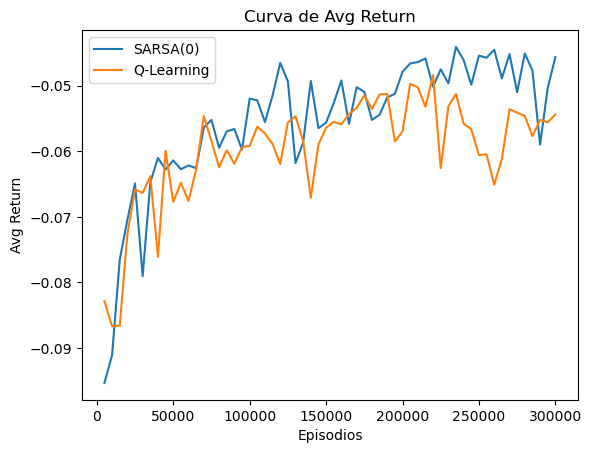

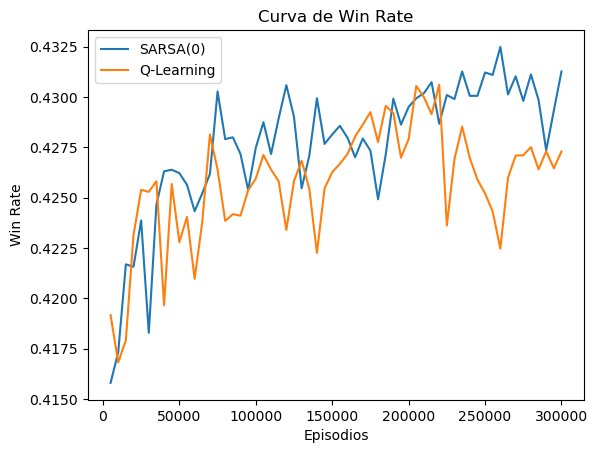

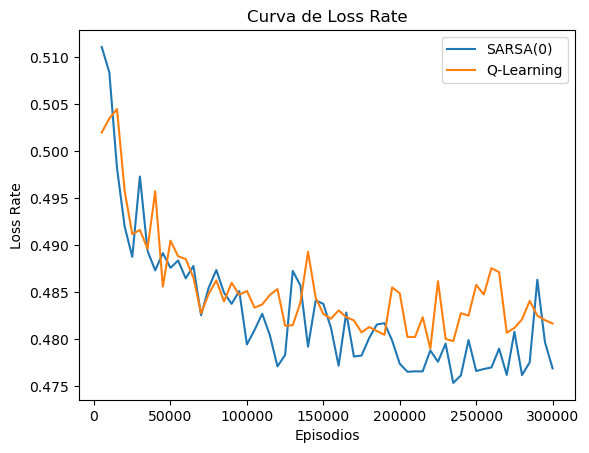

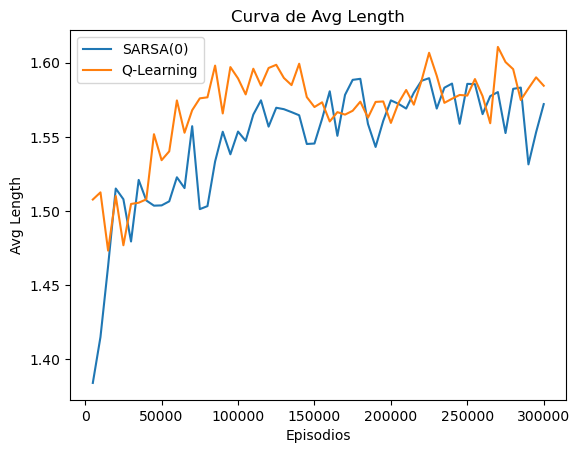

In [22]:

histories = {
    "SARSA(0)": hist_sarsa,
    "Q-Learning": hist_q,
}
plot_learning_curves(histories)


### **Evaluación final (greedy) de las políticas aprendidas**

In [23]:

METRIC_EVAL_EPISODES = 100_000

metrics_sarsa = evaluate_policy(Q_sarsa, num_episodes=METRIC_EVAL_EPISODES, epsilon_eval=0.0)
metrics_q      = evaluate_policy(Q_q,      num_episodes=METRIC_EVAL_EPISODES, epsilon_eval=0.0)

if HAS_PANDAS:
    df = pd.DataFrame([
        {"Algoritmo": "SARSA(0)", **metrics_sarsa},
        {"Algoritmo": "Q-Learning", **metrics_q},
    ])
    display(df)
else:
    print("SARSA(0):", metrics_sarsa)
    print("Q-Learning:", metrics_q)


,Algoritmo,avg_return,win_rate,draw_rate,loss_rate,avg_length
0,SARSA(0),-0.05323,0.42744,0.09189,0.48067,1.57102
1,Q-Learning,-0.05136,0.42872,0.09120,0.48008,1.58456


### **valuación de Monte Carlo**

In [24]:

MC_Q_PATH = "montecarlo_q.pkl"
mc_eval = safe_eval_mc_q(mc_q_path=MC_Q_PATH, eval_episodes=100_000)

if mc_eval is not None:
    Q_mc, metrics_mc = mc_eval
    if HAS_PANDAS:
        df_all = pd.DataFrame([
            {"Algoritmo": "SARSA(0)", **metrics_sarsa},
            {"Algoritmo": "Q-Learning", **metrics_q},
            {"Algoritmo": "Monte Carlo", **metrics_mc},
        ])
        display(df_all)
    else:
        print("(MC) Monte Carlo:", metrics_mc)
else:
    print("No se evaluó Monte Carlo porque no se proporcionó un archivo Q válido.")


,Algoritmo,avg_return,win_rate,draw_rate,loss_rate,avg_length
0,SARSA(0),-0.05323,0.42744,0.09189,0.48067,1.57102
1,Q-Learning,-0.05136,0.42872,0.09120,0.48008,1.58456
2,Monte Carlo,-0.07444,0.42598,0.07360,0.50042,1.34345



### **Conclusiones** 

Con 300000 episodios de entrenamiento y 100000 de evaluación, Q-Learning obtuvo el mejor retorno promedio (-0.051) y la menor tasa de derrotas (0.480). SARSA quedó muy cerca (retorno -0.053, derrotas 0.481). Monte Carlo fue peor (retorno -0.074, derrotas 0.500). Los métodos por diferencias temporales jugaron episodios un poco más largos, cerca de 1.58 pasos, frente a 1.34 de Monte Carlo, y eso se tradujo en menos derrotas y más empates. En este problema conviene usar TD, de preferencia Q-Learning.